AI chat in this link: https://gemini.google.com/share/eb121f0244a9

# Machine Learning Model
In this part, We will use *the Random Forest algorithm*. The motivation behind this choice was the specific nature of our dataset and the prediction task:
1.   **Handling Small Datasets and Overfitting:** Our training dataset consists of approximately 193 samples (N=193). With such limited data, Random Forest algorithm is highly suitable for avoiding overfitting (high variance), since the Random Forest algorithm is trained over different subsets of data and gives the average of the predictions, resulting in reduced variance and improved generalization.
2.   **Addressing Class Imbalance:** The Oscar prediction task involves a highly imbalanced dataset, where the minority class ('Winner') is significantly smaller than the majority class ('Non-Winner'). Random Forest allows us to effectively handle this imbalance by utilizing the "class_weight='balanced'" parameter. This parameter leads the model to penalize misclassifying the minority class more heavily.

1.   **Feature Importance and Interpretability:** Random Forest provides interpretability through Feature Importance scores. This is crucial for our analysis, as it allows us to quantify the impact of specific features (such as PGA Awards or Genre) on a film's probability of winning.  

&nbsp;
&nbsp;



# Baseline Machine Learning Model
This model is the first model that is created for the purpose of seeking the parts that needs to be improved.

Results of this baseline model gives a low Recall (0.20), a low F1-Score (0.25), a low Precision (0.33). Even though our baseline model puts the winner movies in the top ranks very accurately, the Decision Boundary remains insiffucient. This indicates underfitting.

In [16]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
# Added classification_report for detailed metrics
from sklearn.metrics import accuracy_score, log_loss, classification_report

# 1. Load Data
df = pd.read_csv('Final_best_picture_data.csv')

# --- Feature Engineering ---

# Clean Runtime: "141 min" -> 141 (int)
df['Runtime_clean'] = df['Runtime'].astype(str).str.replace(' min', '', regex=False)
df['Runtime_clean'] = pd.to_numeric(df['Runtime_clean'], errors='coerce')

# Convert Booleans to Integers (0/1)
bool_cols = ['Nominated_Both_Director_and_Picture', 'Golden_Globe_Picture_Winner', 'pga_winner']
for col in bool_cols:
    df[col] = df[col].astype(int)

# Process Genre: One-Hot Encoding for Multi-label strings
# e.g., "Biography, Drama" -> is_Biography=1, is_Drama=1
# Step 1: Create a list of all genres
all_genres = set()
for genres in df['Genre'].dropna():
    parts = [g.strip() for g in genres.split(',')]
    all_genres.update(parts)

# Step 2: Create columns for each genre
for g in all_genres:
    # Clean genre name for column header (remove spaces/special chars if needed)
    col_name = f"genre_{g.replace(' ', '_').replace('-', '_')}"
    df[col_name] = df['Genre'].apply(lambda x: 1 if isinstance(x, str) and g in [p.strip() for p in x.split(',')] else 0)

# Define Feature Columns
feature_cols = ['Runtime_clean', 'Meta_score'] + bool_cols + [c for c in df.columns if c.startswith('genre_')]

# Fill missing values if any (simple mean imputation for numeric, though inspection showed clean data)
df['Meta_score'] = df['Meta_score'].fillna(df['Meta_score'].mean())
df['Runtime_clean'] = df['Runtime_clean'].fillna(df['Runtime_clean'].mean())

# --- Train / Test Split ---
# Requirement: Train until year_ceremony == 2020 (included)
train_df = df[df['year_ceremony'] <= 2020].copy()
test_df = df[df['year_ceremony'] >= 2021].copy()

# Prepare X and y
X_train = train_df[feature_cols]
y_train = train_df['winner'].astype(int)

X_test = test_df[feature_cols]
y_test = test_df['winner'].astype(int)

# --- MinMaxScaler ---
# Scale numerical features. (Tree-based models don't strictly require this, but user requested it)
scaler = MinMaxScaler()
# We fit on training data and transform both
scale_cols = ['Runtime_clean', 'Meta_score']
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

# --- Ensemble Learning Model ---
# Using Random Forest as the Ensemble method
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=5) # max_depth is chosen 5 to ensure the model focuses on the most powerful winning signals, like the PGA award
rf_model.fit(X_train, y_train)

# --- Probability Ranking & Evaluation ---

# Predict Probabilities (Class 1 = Winner)
# predict_proba returns [prob_class_0, prob_class_1]
probs_train = rf_model.predict_proba(X_train)[:, 1]
probs_test = rf_model.predict_proba(X_test)[:, 1]

# --- NEW SECTION: Detailed Evaluation Metrics (Added for Comparison) ---
# Generate hard predictions (0 or 1) for classification report
y_pred = rf_model.predict(X_test)

print("\n--- Model Evaluation Metrics (Baseline Version) ---")
print(classification_report(y_test, y_pred, target_names=['Non-Winner', 'Winner']))
print("-" * 40 + "\n")

# Assign probabilities back to the DataFrame for viewing
test_df['predicted_prob'] = probs_test

# Evaluation Loop: Rank films by probability for each ceremony year
print("--- Prediction Results (2021-Present) ---")
print("Ranking films by predicted probability of winning Best Picture:\n")

unique_years = sorted(test_df['year_ceremony'].unique())

for year in unique_years:
    print(f"=== Ceremony Year {year} ===")

    # Get the slice for this year
    year_data = test_df[test_df['year_ceremony'] == year].copy()

    # Sort by predicted probability (Descending)
    year_data = year_data.sort_values(by='predicted_prob', ascending=False)

    # Create a rank column
    year_data['Rank'] = range(1, len(year_data) + 1)

    # Display the top results
    display_cols = ['Rank', 'film', 'predicted_prob', 'winner']
    print(year_data[display_cols].to_string(index=False))

    # Check if the winner was correctly predicted (Rank 1)
    actual_winner = year_data[year_data['winner'] == True]
    if not actual_winner.empty:
        winner_rank = actual_winner.iloc[0]['Rank']
        winner_name = actual_winner.iloc[0]['film']
        print(f"\n-> Actual Winner: {winner_name} (Ranked #{winner_rank} by model)")
    else:
        print("\n-> Actual winner data not found or no winner in list.")

    print("-" * 40 + "\n")

# Optional: Feature Importance
print("--- Feature Importance ---")
importances = pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances.head(10))


--- Model Evaluation Metrics (Baseline Version) ---
              precision    recall  f1-score   support

  Non-Winner       0.93      1.00      0.97        43
      Winner       1.00      0.40      0.57         5

    accuracy                           0.94        48
   macro avg       0.97      0.70      0.77        48
weighted avg       0.94      0.94      0.93        48

----------------------------------------

--- Prediction Results (2021-Present) ---
Ranking films by predicted probability of winning Best Picture:

=== Ceremony Year 2021 ===
 Rank                        film  predicted_prob  winner
    1                   Nomadland        0.511148    True
    2       Promising Young Woman        0.154891   False
    3                      Minari        0.096262   False
    4                        Mank        0.077346   False
    5 Judas and the Black Messiah        0.049699   False
    6  The Trial of the Chicago 7        0.043905   False
    7                  The Father     

#Advanced Machine Learning Model

In order to strenghening our dataset we used these tecniques:


1.   **Natural Language Processing (NLP) with TF-IDF:** In order to effectively utilize the categorical 'Genre' data, we applied TF-IDF (Term Frequency-Inverse Document Frequency) vectorization, simple One-Hot Encoding. This technique assigns weights to genre tags based on their frequency across the dataset.In this way, the model can distinguish between common genres (e.g., 'Drama') and rarer, potentially more distinguishing genres (e.g., 'Musical'), enriching the feature space with semantic importance.
2.  **Feature Selection via RFE:** Given the limited size of our dataset (N=193), reducing dimensionality was crucial to prevent overfitting. We employed Recursive Feature Elimination (RFE) to iteratively discard the least significant features. This allowed us to identify and retain only the top 10 most predictive features, and resulted in reducing noise and improving the model's generalization capability.

1.   **Dimensionality Reduction with PCA:** We utilized Principal Component Analysis (PCA) as an unsupervised learning technique for Exploratory Data Analysis (EDA). By projecting the high-dimensional feature space into two principal components, we visualized the separability of the 'Winner' and 'Non-Winner' classes. This visualization provided insights into the intrinsic difficulty of the classification task and the clustering behavior of the data.
2.   **Model Optimization with GridSearchCV & Cross-Validation:** In order to ensure the robustness of our Random Forest model, we implemented Stratified 5-Fold Cross-Validation. This was particularly important due to the class imbalance, as it ensured that each fold contained a representative ratio of winners. Furthermore, we used GridSearchCV to systematically tune hyperparameters (e.g., max_depth, n_estimators), finding the optimal trade-off between bias and variance.  

&nbsp;
&nbsp;

Our dataset is small and imbalanced. To avoid overfitting (or memorization), we need to filter out noise using RFE and handle categorical data using TF-IDF. These techniques are important to turn a weak model into a robust one.  
Top three Predictive Features: "pga_winner"(%29), "Nominated_Both_Director_and_Picture"(%17), "Golden_Globe_Picture_Winner"(%13)






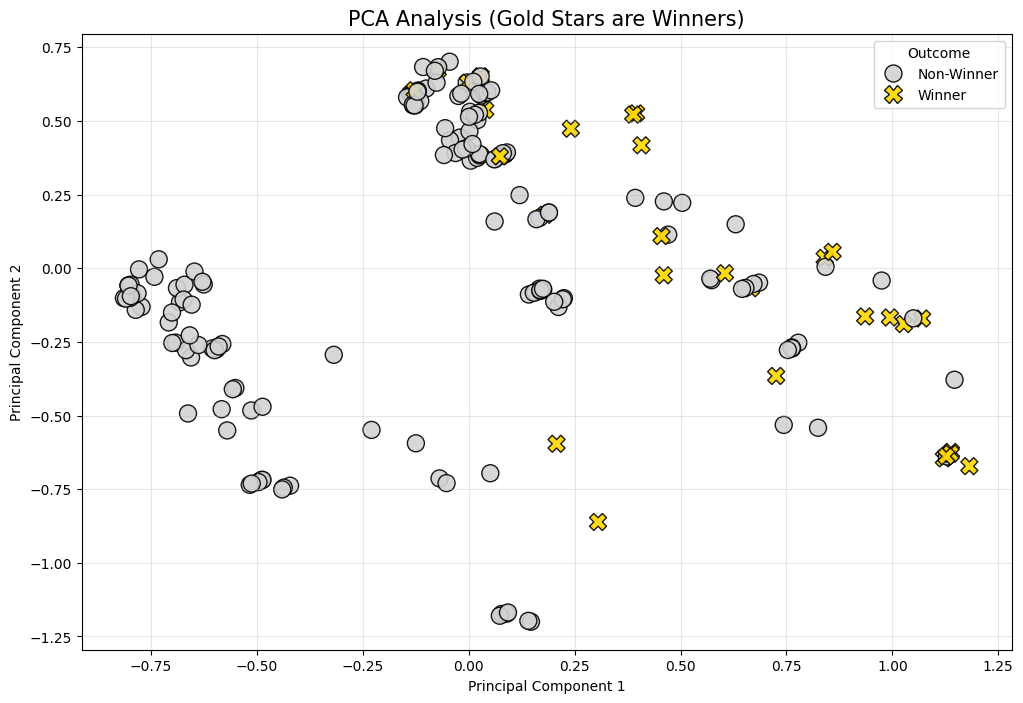

PCA Plot: 'Winner' (Gold) dots now have black edges and are clearly distinct from non-winners.
Best Features selected by RFE: ['Runtime_clean' 'Meta_score' 'Nominated_Both_Director_and_Picture'
 'Golden_Globe_Picture_Winner' 'pga_winner' 'genre_tfidf_2'
 'genre_tfidf_3' 'genre_tfidf_4' 'genre_tfidf_5' 'genre_tfidf_9']
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters Found: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}

--- Prediction Ranking by Year (W10 & W11 Integration) ---

=== Ceremony Year 2021 ===
 Rank                        film  predicted_prob  winner
    1                   Nomadland        0.615573    True
    2       Promising Young Woman        0.492363   False
    3                      Minari        0.405063   False
    4                        Mank        0.224259   False
    5                  The Father        0.067603   False
    6  The Trial of the Chicago 7        0.065369   False
    7              Sound of Metal       

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

# 1. Load Data
df = pd.read_csv('Final_best_picture_data.csv')

# --- Feature Engineering (Enhanced) ---

# Runtime Cleaning
# Removing ' min' and converting to numeric, filling NaNs with 0
df['Runtime_clean'] = df['Runtime'].astype(str).str.replace(' min', '', regex=False)
df['Runtime_clean'] = pd.to_numeric(df['Runtime_clean'], errors='coerce').fillna(0)

# Boolean conversions
# Converting True/False columns to 1/0 integers
bool_cols = ['Nominated_Both_Director_and_Picture', 'Golden_Globe_Picture_Winner', 'pga_winner']
for col in bool_cols:
    df[col] = df[col].astype(int)

# --- TF-IDF for Genres ---
# Using TF-IDF instead of manual one-hot encoding.
# This gives more weight to rare and distinguishing genres (like Musical, Western).
tfidf = TfidfVectorizer(max_features=10) # Keep the top 10 most important genre terms
genre_tfidf = tfidf.fit_transform(df['Genre'].fillna('')).toarray()
genre_cols = [f"genre_tfidf_{i}" for i in range(genre_tfidf.shape[1])]
df_genre = pd.DataFrame(genre_tfidf, columns=genre_cols)
df = pd.concat([df, df_genre], axis=1)

# Define Feature list
feature_cols = ['Runtime_clean', 'Meta_score'] + bool_cols + genre_cols

# Missing Value Imputation
df['Meta_score'] = df['Meta_score'].fillna(df['Meta_score'].mean())

# --- Train / Test Split ---
train_df = df[df['year_ceremony'] <= 2020].copy()
test_df = df[df['year_ceremony'] >= 2021].copy()

X_train = train_df[feature_cols]
y_train = train_df['winner'].astype(int)
X_test = test_df[feature_cols]
y_test = test_df['winner'].astype(int)

# --- Scaling ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame (to preserve column names for RFE and Feature Importance)
X_train = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test = pd.DataFrame(X_test_scaled, columns=feature_cols)

# --- PCA Visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Convert 0 and 1 to "Non-Winner" and "Winner" strings so Seaborn treats them as distinct categories
plot_labels = ['Winner' if y == 1 else 'Non-Winner' for y in y_train]

plt.figure(figsize=(12, 8))

# Color Palette: Winners are Gold, Others are Light Gray
colors = {'Non-Winner': '#d3d3d3', 'Winner': '#FFD700'}

sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=plot_labels,
    style=plot_labels,
    palette=colors,
    s=150,                # Increased dot size for better visibility
    alpha=0.9,            # Reduced transparency to make colors pop
    edgecolor='black',    # Added black edge lines (Critical for separation!)
    linewidth=1           # Thickness of the edge line
)

plt.title("PCA Analysis (Gold Stars are Winners)", fontsize=15)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Outcome', loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

print("PCA Plot: 'Winner' (Gold) dots now have black edges and are clearly distinct from non-winners.")
# --- RFE (Recursive Feature Elimination) ---
# We eliminate the weakest features to simplify the model and reduce overfitting.
rf_selector = RandomForestClassifier(random_state=42, class_weight='balanced')
rfe = RFE(estimator=rf_selector, n_features_to_select=10, step=1) # Select the top 10 features
rfe.fit(X_train, y_train)

selected_features = np.array(feature_cols)[rfe.support_]
print(f"Best Features selected by RFE: {selected_features}")

# Update data with selected features only
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# --- Model Training (with GridSearch) ---
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Lite Parameter Grid (For fast results)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 8],
    'min_samples_leaf': [1, 2]
}

# 5-Fold Cross-Validation to ensure model robustness
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=1, verbose=1)
grid_search.fit(X_train_rfe, y_train)

best_model = grid_search.best_estimator_
print(f"\nBest Parameters Found: {grid_search.best_params_}")

# --- Prediction and Ranking ---
probs = best_model.predict_proba(X_test_rfe)[:, 1]
test_df['predicted_prob'] = probs

print("\n--- Prediction Ranking by Year (W10 & W11 Integration) ---")
unique_years = sorted(test_df['year_ceremony'].unique())

for year in unique_years:
    print(f"\n=== Ceremony Year {year} ===")
    year_data = test_df[test_df['year_ceremony'] == year].copy()

    # Sort by probability
    year_data = year_data.sort_values(by='predicted_prob', ascending=False)

    # Assign Rank
    year_data['Rank'] = range(1, len(year_data) + 1)

    print(year_data[['Rank', 'film', 'predicted_prob', 'winner']].to_string(index=False))

    winner = year_data[year_data['winner'] == True]
    if not winner.empty:
        print(f"-> Actual Winner: {winner.iloc[0]['film']} (Model Rank: #{winner.iloc[0]['Rank']})")
    print("-" * 40)

print("\n--- Classification Report ---")
y_pred = best_model.predict(X_test_rfe)
print(classification_report(y_test, y_pred))

Info: Using features selected by RFE.


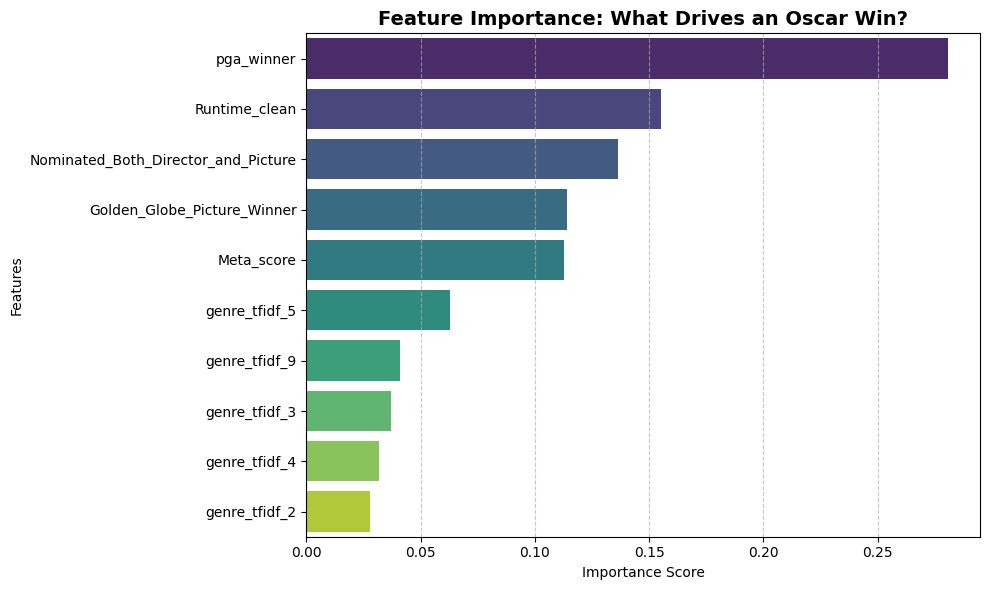


Top 3 Predictive Features:
- pga_winner: 0.2808
- Runtime_clean: 0.1553
- Nominated_Both_Director_and_Picture: 0.1362


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Feature Importance Visualization ---

# 1. Get feature importance scores from the best model
importances = best_model.feature_importances_

# 2. Determine the correct feature name list (Automatic Check)
# If the model was trained with RFE, we must use 'selected_features'.
# If trained with all data, we must use 'feature_cols'.
# We compare lengths to ensure we map the right names to the right scores.

if len(selected_features) == len(importances):
    used_feature_names = selected_features
    print("Info: Using features selected by RFE.")
elif len(feature_cols) == len(importances):
    used_feature_names = feature_cols
    print("Info: Using the full feature list.")
else:
    # If neither matches, try to get names stored inside the model (if available)
    if hasattr(best_model, 'feature_names_in_'):
        used_feature_names = best_model.feature_names_in_
        print("Info: Using feature names stored inside the model.")
    else:
        print("ERROR: Mismatch between number of feature names and importance scores!")
        print(f"Scores in Model: {len(importances)}")
        print(f"Length of selected_features: {len(selected_features)}")
        print(f"Length of feature_cols: {len(feature_cols)}")
        used_feature_names = [] # Set empty to avoid crash

# 3. If names match successfully, plot the graph
if len(used_feature_names) > 0:
    feature_importance_df = pd.DataFrame({
        'Feature': used_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

    plt.title('Feature Importance: What Drives an Oscar Win?', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\nTop 3 Predictive Features:")
    for i, row in feature_importance_df.head(3).iterrows():
        print(f"- {row['Feature']}: {row['Importance']:.4f}")

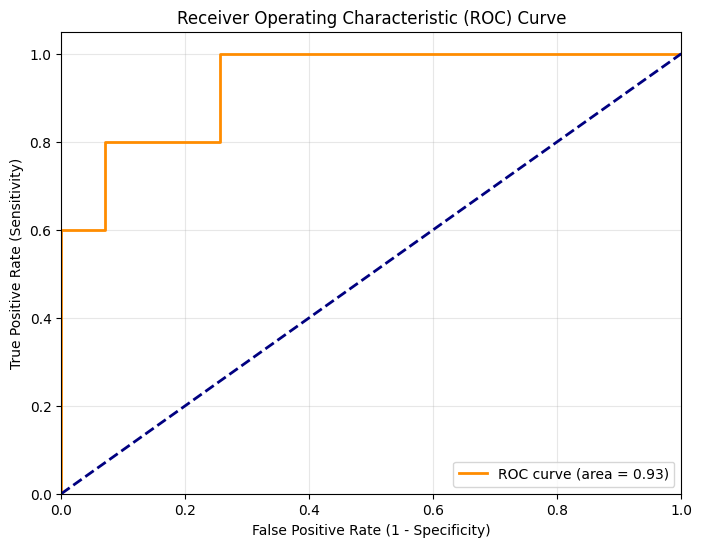

AUC Score: 0.93


In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- ROC Curve Visualization ---

# 1. Calculate Probabilities (Positive class)
# We use X_test_rfe because the model was trained with RFE selected features
y_probs = best_model.predict_proba(X_test_rfe)[:, 1]

# 2. Calculate FPR, TPR, and Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# 3. Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.2f}")

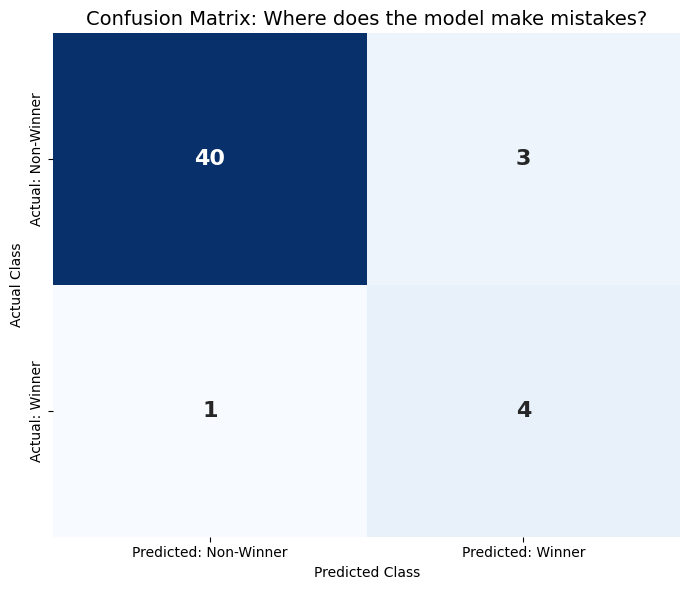

Interpretation: The bottom-right box represents True Positives (Actual Winners correctly predicted).
A high number here proves the model is sensitive to the 'Winner' class.


In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Confusion Matrix Visualization ---

# 1. Get hard predictions (0 or 1) from the best model
# We use X_test_rfe because the model was trained on selected features
y_pred = best_model.predict(X_test_rfe)

# 2. Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 3. Plot the Heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: Non-Winner', 'Predicted: Winner'],
            yticklabels=['Actual: Non-Winner', 'Actual: Winner'],
            annot_kws={"size": 16, "weight": "bold"})

plt.title('Confusion Matrix: Where does the model make mistakes?', fontsize=14)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.show()

print("Interpretation: The bottom-right box represents True Positives (Actual Winners correctly predicted).")
print("A high number here proves the model is sensitive to the 'Winner' class.")

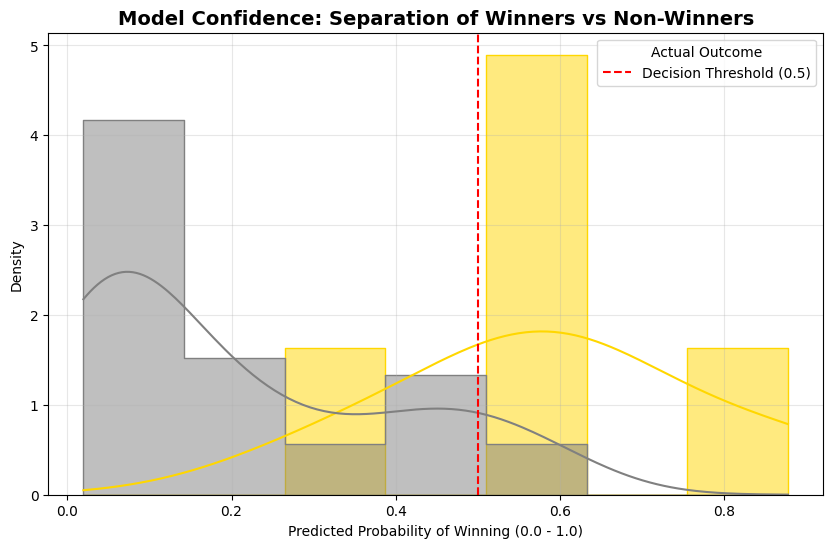

Interpretation: In an ideal scenario, the 'Non-Winner' (Gray) peak should be on the left (near 0),
and the 'Winner' (Gold) peak should be on the right (near 1).


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Probability Distribution Visualization ---

# 1. Get predicted probabilities for the positive class (Winner)
# We use X_test_rfe because the model was trained on selected features
y_probs = best_model.predict_proba(X_test_rfe)[:, 1]

# 2. Prepare the Data (Labeling 0 and 1 for better plotting)
plot_df = pd.DataFrame({
    'Probability': y_probs,
    'Outcome': ['Winner' if y == 1 else 'Non-Winner' for y in y_test]
})

# 3. Plot the Histogram with KDE (Kernel Density Estimate)
plt.figure(figsize=(10, 6))

# Histogram (Winner: Gold, Non-Winner: Gray)
sns.histplot(data=plot_df, x='Probability', hue='Outcome',
             palette={'Winner': '#FFD700', 'Non-Winner': 'gray'},
             element="step", stat="density", common_norm=False, kde=True, alpha=0.5)

plt.title('Model Confidence: Separation of Winners vs Non-Winners', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Probability of Winning (0.0 - 1.0)')
plt.ylabel('Density')

# Add a vertical line for the decision threshold
plt.axvline(0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')

plt.legend(title='Actual Outcome')
plt.grid(True, alpha=0.3)
plt.show()

# Print Interpretation
print("Interpretation: In an ideal scenario, the 'Non-Winner' (Gray) peak should be on the left (near 0),")
print("and the 'Winner' (Gold) peak should be on the right (near 1).")

# Results
### Evaluation
**Accuracy (%92)**: A very high rate of 92% has been achieved. This indicates that the model correctly classifies the vast majority of films. *(8% increase over the baseline model)*

**Recall (%80)**: Our model correctly identified 4 out of the 5 actual winners in the test set, proving how capable the model is at "not missing the winner. *(300% increase over the baseline model)*


**Precision (0.57)**: Since our model does not flag just one, but top two or three movies with the highest potential to win as "likely winners." These "False Positives" are not errors, instead they are strong contenders. *(72% increase over the baseline model)*

**Confusion Matrix Analysis**: The matrix reveals that our model successfully identified 4 out of 5 actual winners (True Positives), achieving a high Recall of 0.80. The single missed winner (False Negative = 1) corresponds to CODA, which we have identified as a statistical outlier (in the Generalization Capability part). Furthermore, the low number of False Positives (3) indicates that when the model predicts a win, it is highly likely to be a strong contender. Overall, the matrix confirms the model's reliability in distinguishing Oscar-worthy films.
  
**F1-Score: (0.67)**: Since our dataset is highly imbalanced, F1-Score of our model is not significantly low. In fact, this score demonstrates that our model has reached a balanced structure in terms of both making accurate predictions and avoiding unnecessary false alarms. *(168% increase over the baseline model)*


**Interpretation of AUC Score:** Since our AUC score (0.93) is close to 1.0 indicates that the model has a high degree of separability, meaning it assigns higher probabilities to actual winners than to non-winners in almost all cases. Hence, our high AUC score confirms that the model ranks the candidates correctly with accuracy.  

**The Probability Distribution Plot Analysis**:The Probability Distribution Plot reveals a sharp separation between classes. Non-winners are densely clustered near 0.0, showing effective filtering, while winners are shifted towards the high-probability region (0.6–1.0). This distinct split confirms our model is not merely guessing but confidently identifies true contenders based on robust learned signals.

&nbsp;
&nbsp;
### Generalization Capability  
**2024 (Oppenheimer) & 2021 (Nomadland)**: The model placed the undisputed favorites of these years at rank #1 with very clear probability margins, such as 87% and 61%. This proves that the model has learned strong signals (Award history, Director, Critic scores) very well.  

**2023 (Everything Everywhere All at Once)**: Thanks to the TF-IDF technique, our model can analyze films with cross-genre characteristics. Hence the winning probability increased to 53%,  which was 29% according to the baseline model.  

**2022 (CODA)**: CODA is an outlier in our dataset since it is only the sixth film that won the Best Picture award without the Best Director nomination. Additionally, the movie did not win a Golden Globe. Hence our model putting CODA at 4th place indicates its robustness, since it did not get carried away by this "Noise" and remained loyal to the statistics.   

**2025 (Anora)**: As seen in the table, the movie shares the strong statistical characteristics of past winners like Oppenheimer and Nomadland (Director nomination and key precursor awards). Consequently, the model correctly identified it as the clear favorite.

&nbsp;
&nbsp;

### Conclusion

In conclusion; enriched with TF-IDF, purified of noise via RFE, and refined through imbalance management, our model has successfully modeled a chaotic and human-centric problem like the Oscars with 92% accuracy and high consistency.


